In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=[]

env: CUDA_VISIBLE_DEVICES=[]


### Marmoset vocalizations
Source:
- local: /mnt/cube/Datasets/Marmosets/FromMillerLab
- /mnt/cube/tsainbur/Projects/github_repos/generativevocalizationnetwork/notebooks/marmoset_vocalizations/

In [2]:
from pathlib2 import Path
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import IPython

In [3]:
from avgn_paper.signalprocessing import spectrogramming as sg

In [4]:
import pdb
from joblib import Parallel, delayed
n_jobs = 10
verbosity = 5

In [5]:
from tqdm.autonotebook import tqdm
from librosa.core.time_frequency import mel_frequencies
from avgn_paper.signalprocessing.spectrogramming_tf import spectrogram_tensorflow
from avgn_paper.utils.audio import load_wav, float32_to_int16, int16_to_float32, write_wav
from avgn_paper.visualization.spectrogram import visualize_spec, plot_spec
from avgn_paper.utils.general import HParams
from avgn_paper.signalprocessing.filtering import butter_bandpass_filter

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### data locations

In [6]:
DSLOC = Path('/mnt/cube/Datasets/Marmosets/FromMillerLab')

### Parse Wav info

In [7]:
wavs = list(DSLOC.glob('*.wav'))
wavs[:3]

[PosixPath('/mnt/cube/Datasets/Marmosets/FromMillerLab/han.todd.170621.wav'),
 PosixPath('/mnt/cube/Datasets/Marmosets/FromMillerLab/ares_spn_230217_203.wav'),
 PosixPath('/mnt/cube/Datasets/Marmosets/FromMillerLab/ares_ant_010317_33.wav')]

In [8]:
wav_df = pd.DataFrame(columns=['monkey1', 'monkey2', 'date', 'date_idx', '_loc'])
for _wav in wavs:
    if _wav.stem[0]=='.':
        continue
    monkey1 = None
    date = None
    monkey2 = None
    date_idx = None
    
    wav_split = _wav.stem.split('_')
    if len(wav_split) == 3:
        monkey1, monkey2, date = wav_split
    elif len(wav_split) == 4:
        monkey1, monkey2, date, date_idx = wav_split
    elif len(wav_split) == 1:
        if len(_wav.stem.split('.')) == 3:
            monkey1, monkey2, date = _wav.stem.split('.')
        elif len(_wav.stem.split('.')) == 2:
            monkey1, date_idx = _wav.stem.split('.')
        elif len(_wav.stem.split('.')) == 4:
            monkey1, date_idx, date, _ = _wav.stem.split('.')
        elif len(re.findall('[A-Z][^A-Z]*', _wav.stem)) == 2:
            monkey1, date_idx = re.findall('[A-Z][^A-Z]*', _wav.stem)
        else: 
            continue
            
    wav_df.loc[len(wav_df)] = [monkey1, monkey2, date, date_idx, _wav]

In [9]:
print(len(wav_df))

183


In [10]:
wav_df[:3]

,monkey1,monkey2,date,date_idx,_loc
0,han,todd,170621,None,/mnt/cube/Datasets/Marmosets/FromMillerLab/han...
1,ares,spn,230217,203,/mnt/cube/Datasets/Marmosets/FromMillerLab/are...
2,ares,ant,010317,33,/mnt/cube/Datasets/Marmosets/FromMillerLab/are...


### parse matfiles

In [11]:
matfiles =list(DSLOC.glob('*.mat'))

In [12]:
mf_df = pd.DataFrame(columns=['monkey1', 'monkey2', 'date', 'date_idx', '_loc'])
for _mf in matfiles:
    monkey1 = None
    date = None
    monkey2 = None
    date_idx = None
    
    wav_split = _mf.stem.split('_')
    if len(wav_split) == 3:
        monkey1, monkey2, date = wav_split
    elif len(wav_split) == 4:
        monkey1, monkey2, date, date_idx = wav_split
    elif len(wav_split) == 1:
        if len(_mf.stem.split('.')) == 3:
            monkey1, monkey2, date = _mf.stem.split('.')
        elif len(_mf.stem.split('.')) == 2:
            monkey1, date_idx = _mf.stem.split('.')
        elif len(_mf.stem.split('.')) == 4:
            monkey1, monkey2, date_idx, _ = _mf.stem.split('.')
        elif len(re.findall('[A-Z][^A-Z]*', _mf.stem)) == 2:
            monkey1, date_idx = re.findall('[A-Z][^A-Z]*', _mf.stem)
        else: 
            continue
    mf_df.loc[len(mf_df)] = [monkey1, monkey2, date, date_idx, _mf]

In [13]:
print(len(mf_df))
mf_df[:3]

82


,monkey1,monkey2,date,date_idx,_loc
0,apollo,angel,140217,None,/mnt/cube/Datasets/Marmosets/FromMillerLab/apo...
1,jasmine,hermes,170622,None,/mnt/cube/Datasets/Marmosets/FromMillerLab/jas...
2,aladdin,banana,060317,None,/mnt/cube/Datasets/Marmosets/FromMillerLab/ala...


### match matfiles and waveforms

In [14]:
wav_df['Annotations'] = False
for idx, row in wav_df.iterrows():
    mm1 = (mf_df.monkey1 == row.monkey1)
    mm2 = (mf_df.monkey2 == row.monkey2)
    md = (mf_df.date == row.date)
    #mix = (mf_df.date_idx == row.date_idx)
    mf_match = mf_df[mm1 & mm2 & md]
    if len(mf_match) > 0:
        wav_df.loc[idx, 'Annotations'] = mf_match.index[0]

In [15]:
wav_df[:3]

,monkey1,monkey2,date,date_idx,_loc,Annotations
0,han,todd,170621,None,/mnt/cube/Datasets/Marmosets/FromMillerLab/han...,19
1,ares,spn,230217,203,/mnt/cube/Datasets/Marmosets/FromMillerLab/are...,False
2,ares,ant,010317,33,/mnt/cube/Datasets/Marmosets/FromMillerLab/are...,False


In [16]:
np.sum(wav_df.Annotations.values != False)

79

### get each labelled syllable

In [17]:
from scipy.io import loadmat

In [18]:
# for each wav in annotated wav_df, load the annotations file (mat) grab each of the vocalizations

In [19]:
annotated_wav_df = wav_df[wav_df.Annotations!=False]

In [21]:
def process_marmoset_call(row):

    syllable_df = pd.DataFrame(
        columns=[
            "indv",
            "partner",
            "date",
            "call_type",
            "wav_name",
            "wav",
            "time_in_wav",
            "call_num",
            "call_syll",
            "rate",
            "syll_len",
            "monkey_number"
        ]
    )

    # load the wav
    rate, data = load_wav(row._loc)
    # load the annotations
    annotations = loadmat(mf_df.loc[row.Annotations]._loc)

    # loop through annotations
    for call_ix, call in enumerate(annotations["monkey1_data"]):
        #print(call)
        n_subcalls = int(len(call[1]) / 2)
        call_name = call[0][0]
        for call_sub in range(n_subcalls):
            subcall_start = call[1][call_sub*2]
            subcall_end = call[1][(call_sub*2) + 1]
            print(subcall_start, subcall_end)

            # if this call is too long, its probably a mistake
            if ((subcall_end - subcall_start) > 5) or (
                (subcall_end - subcall_start) <= 0
            ):
                continue

            call_data = data[int(rate * subcall_start) : int(rate * subcall_end), 0]

            syllable_df.loc[len(syllable_df)] = [
                row.monkey1,
                row.monkey2,
                row.date,
                call_name,
                row._loc,
                call_data,
                subcall_start.astype("float32"),
                call_ix,
                call_sub,
                rate,
                len(call_data) / rate,
                1,
            ]

    for call_ix, call in enumerate(annotations["monkey2_data"]):
        n_subcalls = int(len(call[1]) / 2)
        call_name = call[0][0]
        for call_sub in range(n_subcalls):
            subcall_start = call[1][call_sub*2]
            subcall_end = call[1][(call_sub*2) + 1]

            # if this call is too long, its probably a mistake
            if ((subcall_end - subcall_start) > 5) or (
                (subcall_end - subcall_start) <= 0
            ):
                continue

            call_data = data[int(rate * subcall_start) : int(rate * subcall_end), 1]

            syllable_df.loc[len(syllable_df)] = [
                row.monkey2,
                row.monkey1,
                row.date,
                call_name,
                row._loc,
                call_data,
                subcall_start.astype("float32"),
                call_ix,
                call_sub,
                rate,
                len(call_data) / rate,
                2
            ]
    return syllable_df

In [22]:
for idx, row in tqdm(annotated_wav_df.iterrows(), total=len(annotated_wav_df)):
    loadmat(mf_df.loc[row.Annotations]._loc) 

In [23]:
with Parallel(n_jobs=24, verbose=verbosity) as parallel:
    song_dfs = parallel(
        delayed(process_marmoset_call)(row)
        for idx, row in tqdm(annotated_wav_df.iterrows(), total=len(annotated_wav_df))
    )
syllable_df = pd.concat(song_dfs).reset_index()

[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done  24 tasks      | elapsed:    5.2s


[Parallel(n_jobs=24)]: Done  48 out of  79 | elapsed:    7.7s remaining:    5.0s
[Parallel(n_jobs=24)]: Done  64 out of  79 | elapsed:    9.4s remaining:    2.2s
[Parallel(n_jobs=24)]: Done  79 out of  79 | elapsed:   12.0s finished


In [24]:
print(len(syllable_df))
syllable_df[:3]

14125


,index,indv,partner,date,call_type,wav_name,wav,time_in_wav,call_num,call_syll,rate,syll_len,monkey_number
0,0,han,todd,170621,phee,/mnt/cube/Datasets/Marmosets/FromMillerLab/han...,"[5, -2, 0, 3, -3, 1, 3, 3, 0, 1, 3, 3, 1, 0, 1...",[14.792361],0,0,44150,1.259547,1
1,1,han,todd,170621,phee,/mnt/cube/Datasets/Marmosets/FromMillerLab/han...,"[2, 15, 19, 4, 10, 6, -4, 7, 17, 0, 3, 7, 35, ...",[16.272427],0,1,44150,1.047497,1
2,2,han,todd,170621,phee,/mnt/cube/Datasets/Marmosets/FromMillerLab/han...,"[-8, -4, 12, 9, 10, -11, -4, 25, 4, 2, 6, -3, ...",[115.95578],1,0,44150,1.255130,1


In [25]:
np.unique(syllable_df.rate), np.unique(syllable_df.call_syll), np.unique(syllable_df.call_type)

(array([44150], dtype=object),
 array([0, 1, 2, 3, 4, 5, 6], dtype=object),
 array(['phee', 'tsk', 'twitter', 'unknown'], dtype=object))

In [26]:
total_indv_vocs = pd.DataFrame(
    {indv: [np.sum(syllable_df.indv == indv)] for indv in np.unique(syllable_df.indv)}
).T.sort_values(by=0, ascending=False).T
total_indv_vocs

,copper,hank,hermes,todd,waylon,ares,london,han,uno,leo,...,abu,chewie,dip,mango,louie,mowgli,rafiki,kiwi,luna,nasira
0,1809,1671,1671,1231,1209,875,584,558,514,391,...,84,81,66,28,20,12,7,5,3,2


In [27]:
rate = 44150

In [28]:
voc_lens = np.array([len(row.wav)/rate for idx, row in tqdm(
            syllable_df.iterrows(), total = len(syllable_df)
        )])

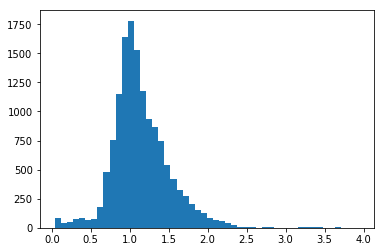

In [29]:
plt.hist(voc_lens[voc_lens<4], bins=50);

In [30]:
np.sum(voc_lens==0), np.sum(voc_lens > 10)

(0, 0)

### create spectrograms for data

In [31]:
from librosa.core.time_frequency import mel_frequencies

In [32]:
win_length_ms = 10
hop_length_ms = 2
print(win_length_ms / 1000 * rate)
print(hop_length_ms / 1000 * rate)

hparams = HParams(
    # spectrogramming
    win_length=int(rate / 1000 * win_length_ms),
    n_fft=1024,
    hop_length=int(rate / 1000 * hop_length_ms),
    ref_level_db=20,
    min_level_db=-60,
    preemphasis=0.97,
    # mel scaling
    num_mel_bins=128,
    mel_lower_edge_hertz=5000,
    mel_upper_edge_hertz=10000,
    # inversion
    power=1.5,  # for spectral inversion
    griffin_lim_iters=50,
    pad=True,
    #
)

# create a filter to convolve with the spectrogram
mel_matrix = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins=hparams.num_mel_bins,
    num_spectrogram_bins=int(hparams.n_fft / 2) + 1,
    sample_rate=rate,
    lower_edge_hertz=hparams.mel_lower_edge_hertz,
    upper_edge_hertz=hparams.mel_upper_edge_hertz,
    dtype=tf.dtypes.float32,
    name=None,
)

# gets the center frequencies of mel bands
mel_f = mel_frequencies(
    n_mels=hparams.num_mel_bins + 2,
    fmin=hparams.mel_lower_edge_hertz,
    fmax=hparams.mel_upper_edge_hertz,
)

# Slaney-style mel is scaled to be approx constant energy per channel (from librosa)
enorm = tf.dtypes.cast(
    tf.expand_dims(
        tf.constant(
            2.0 / (mel_f[2 : hparams.num_mel_bins + 2] - mel_f[: hparams.num_mel_bins])
        ),
        0,
    ),
    tf.float32,
)

mel_matrix = tf.multiply(mel_matrix, enorm)
mel_matrix = tf.divide(mel_matrix, tf.reduce_sum(mel_matrix, axis=0)).numpy()

441.5
88.3


In [33]:
audio = int16_to_float32(syllable_df.wav.values[0])
audio = butter_bandpass_filter(audio, lowcut = 4000, highcut=10000, fs=rate, order=4)
spectrogram = sg.spectrogram(audio, hparams)
mel_spec = np.dot(spectrogram.T, mel_matrix).T

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


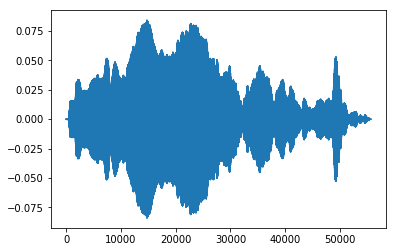

In [34]:
plt.plot(audio)
IPython.display.Audio(data=audio, rate=rate)

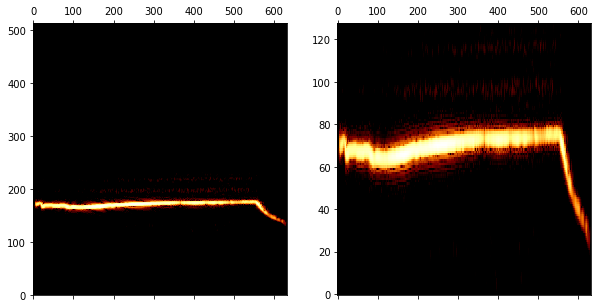

In [35]:
fig, axs = plt.subplots(ncols = 2, figsize=(10,5))
axs[0].matshow(spectrogram, origin='lower', aspect='auto', cmap = plt.cm.afmhot)
axs[1].matshow(mel_spec, origin='lower', aspect='auto', cmap = plt.cm.afmhot)
#ax.axis('off')

In [36]:
from PIL import Image 
def log_resize_spec(spec, spec_len_mul=20, freq_bins = 64):
    resize_shape = [int(np.log(np.shape(spec)[1])*spec_len_mul), freq_bins]
    resize_spec = np.array(Image.fromarray(spec).resize(resize_shape, Image.ANTIALIAS))
    return resize_spec

def pad_spectrogram(spectrogram, pad_length):
    """ Pads a spectrogram to being a certain length
    """
    excess_needed = pad_length - np.shape(spectrogram)[1]
    pad_left = np.floor(float(excess_needed) / 2).astype("int")
    pad_right = np.ceil(float(excess_needed) / 2).astype("int")
    return np.pad(
        spectrogram, [(0, 0), (pad_left, pad_right)], "constant", constant_values=0
    )

def make_spec(data, hparams):
    spectrogram = sg.spectrogram(data, hparams)
    #spectrogram = mask_spec(spectrogram)
    spectrogram = spectrogram/np.max(spectrogram)
    #return spectrogram
    mel_spec = np.dot(spectrogram.T, mel_matrix).T
    mel_spec = mask_spec(mel_spec)
    mel_spec = log_resize_spec(mel_spec)
    mel_spec[mel_spec<0] = 0
    mel_spec = mel_spec/np.max(mel_spec)
    mel_spec = (mel_spec * 255).astype('uint8')
    return mel_spec

def mask_spec(spec, spec_thresh=.9, offset=1e-10):
    mask = spec >= (spec.max(axis=0,keepdims=1)*spec_thresh+offset)
    #plt.matshow(mask)
    return spec*mask

In [37]:
spec = make_spec(int16_to_float32(syllable_df.loc[1000].wav), hparams)

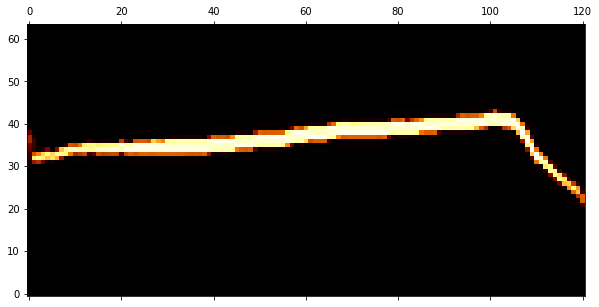

In [38]:
fig, ax = plt.subplots(ncols = 1, figsize=(10,5))
ax.matshow(spec, origin='lower', aspect='auto', cmap = plt.cm.afmhot)
#ax.axis('off')

In [39]:
with Parallel(n_jobs=24, verbose=verbosity) as parallel:
    specs = parallel(
        delayed(make_spec)(int16_to_float32(row.wav), hparams)
        for idx, row in tqdm(
            syllable_df.iterrows(), total = len(syllable_df)
        )
    )

[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done  24 tasks      | elapsed:    2.3s
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=24)]: Done 114 tasks      | elapsed:    2.7s
[Parallel(n_jobs=24)]: Done 331 tasks      | elapsed:    3.4s
[Parallel(n_jobs=24)]: Done 655 tasks      | elapsed:    4.3s
[Parallel(n_jobs=24)]: Done 1413 tasks      | elapsed:    6.0s
[Parallel(n_jobs=24)]: Done 2349 tasks      | elapsed:    9.3s
[Parallel(n_jobs=24)]: Done 3289 tasks      | elapsed:   11.6s
[Parallel(n_jobs=24)]: Done 4511 tasks      | elapsed:   14.9s
[Parallel(n_jobs=24)]: Done 5879 tasks      | elapsed:   17.8s
[Parallel(n_jobs=24)]: Done 7391 tasks      | elapsed:   20.

[Parallel(n_jobs=24)]: Done 14125 out of 14125 | elapsed:   34.2s finished


In [40]:
spec_lens = np.array([np.shape(i)[1] for i in specs])

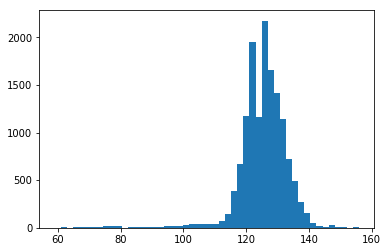

In [41]:
plt.hist(spec_lens, bins=50);

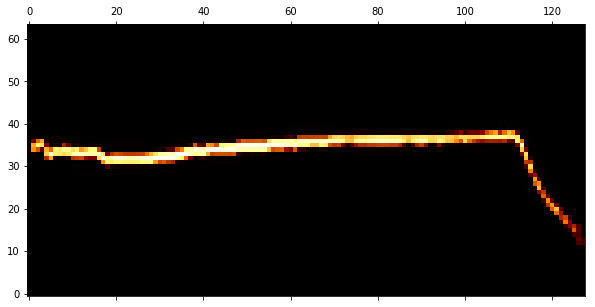

In [42]:
fig, ax = plt.subplots(ncols = 1, figsize=(10,5))
ax.matshow(specs[0], origin='lower', aspect='auto', cmap = plt.cm.afmhot)
#ax.axis('off')

In [43]:
def pad_spectrogram(spectrogram, pad_length):
    """ Pads a spectrogram to being a certain length
    """
    excess_needed = pad_length - np.shape(spectrogram)[1]
    pad_left = np.floor(float(excess_needed) / 2).astype("int")
    pad_right = np.ceil(float(excess_needed) / 2).astype("int")
    return np.pad(
        spectrogram, [(0, 0), (pad_left, pad_right)], "constant", constant_values=0
    )

In [44]:
with Parallel(n_jobs=24, verbose=verbosity) as parallel:
    specs_padded = parallel(
        delayed(pad_spectrogram)(spec, np.max(spec_lens))
        for spec in tqdm(
            specs
        )
    )

[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done 4284 tasks      | elapsed:    0.9s


[Parallel(n_jobs=24)]: Done 14125 out of 14125 | elapsed:    1.9s finished


In [45]:
syllable_df['specs'] = specs_padded

In [46]:
spec = specs_padded[100]

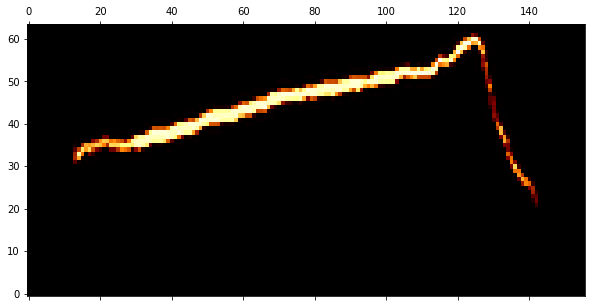

In [47]:
fig, ax = plt.subplots(ncols = 1, figsize=(10,5))
ax.matshow(spec, origin='lower', aspect='auto', cmap = plt.cm.afmhot)
#ax.axis('off')

In [48]:
total_indv_vocs = pd.DataFrame(
    {indv: [np.sum(syllable_df.indv == indv)] for indv in np.unique(syllable_df.indv)}
).T.sort_values(by=0, ascending=False).T
total_indv_vocs

,copper,hank,hermes,todd,waylon,ares,london,han,uno,leo,...,abu,chewie,dip,mango,louie,mowgli,rafiki,kiwi,luna,nasira
0,1809,1671,1671,1231,1209,875,584,558,514,391,...,84,81,66,28,20,12,7,5,3,2


In [49]:
total_indv_vocs.columns

Index(['copper', 'hank', 'hermes', 'todd', 'waylon', 'ares', 'london', 'han',
       'uno', 'leo', 'papaya', 'poseidon', 'banana', 'kit', 'ben', 'iago',
       'william', 'jasmine', 'aladdin', 'angel', 'apollo', 'raja', 'baloo',
       'abu', 'chewie', 'dip', 'mango', 'louie', 'mowgli', 'rafiki', 'kiwi',
       'luna', 'nasira'],
      dtype='object')

In [50]:
largest_indvs = total_indv_vocs.columns[total_indv_vocs.loc[0].values > 1000]
largest_indvs

Index(['copper', 'hank', 'hermes', 'todd', 'waylon'], dtype='object')

In [51]:
def plot_voc_canvas(specs_padded, nrow = 6, ncol = 20, zoom = 2):
    """
    """
    dimx = np.shape(specs_padded[0])[0]
    dimy = np.shape(specs_padded[0])[1]

    canvas = np.zeros((nrow*dimx, ncol*dimy))
    cn = 0
    for row in range(nrow)[::-1]:
        for col in range(ncol):
            canvas[dimx*row:dimx*(row+1), dimy*col:dimy*(col+1)] = specs_padded[cn]
            cn += 1

    fig, ax = plt.subplots(figsize=(ncol*zoom*2, nrow*zoom))
    ax.matshow(canvas, origin='lower', aspect='auto', cmap = plt.cm.afmhot)
    ax.axis('off')
    plt.show()

copper 1699


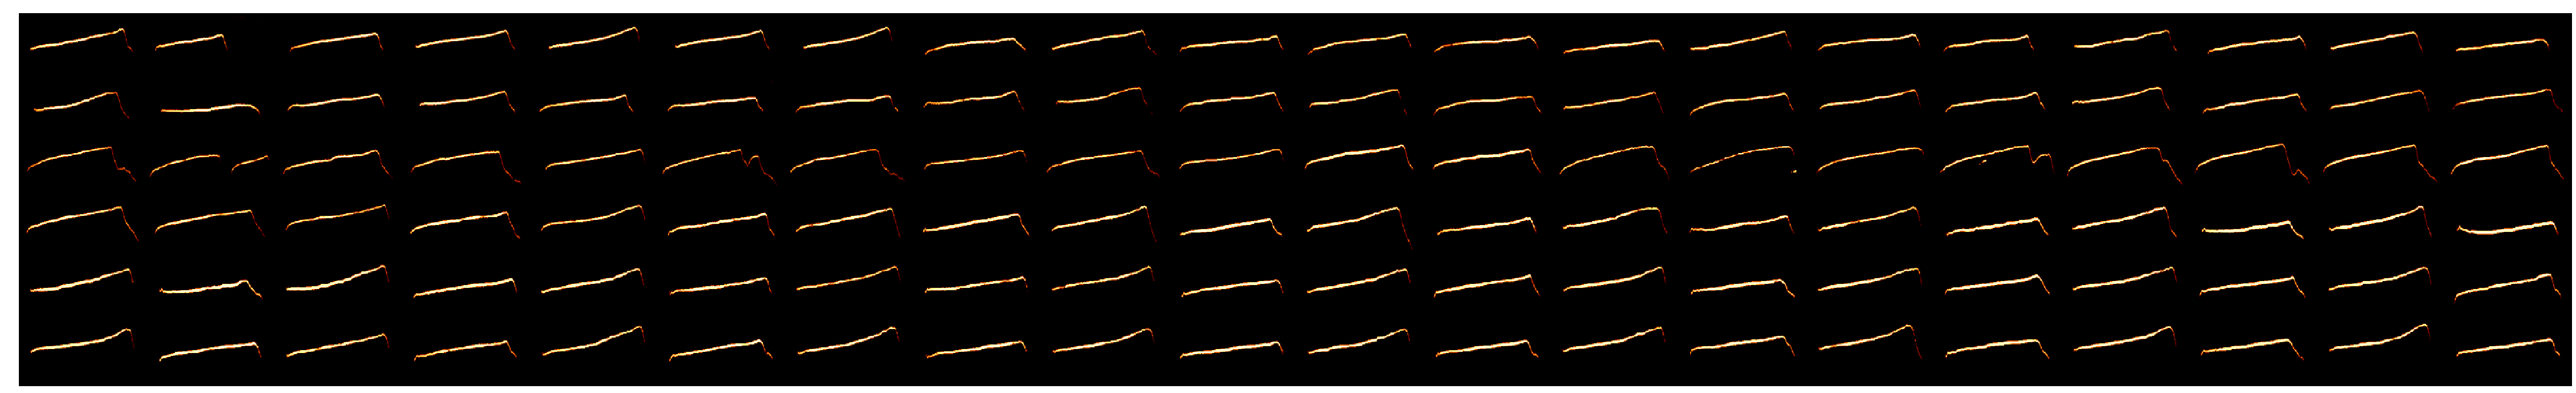

hank 1636


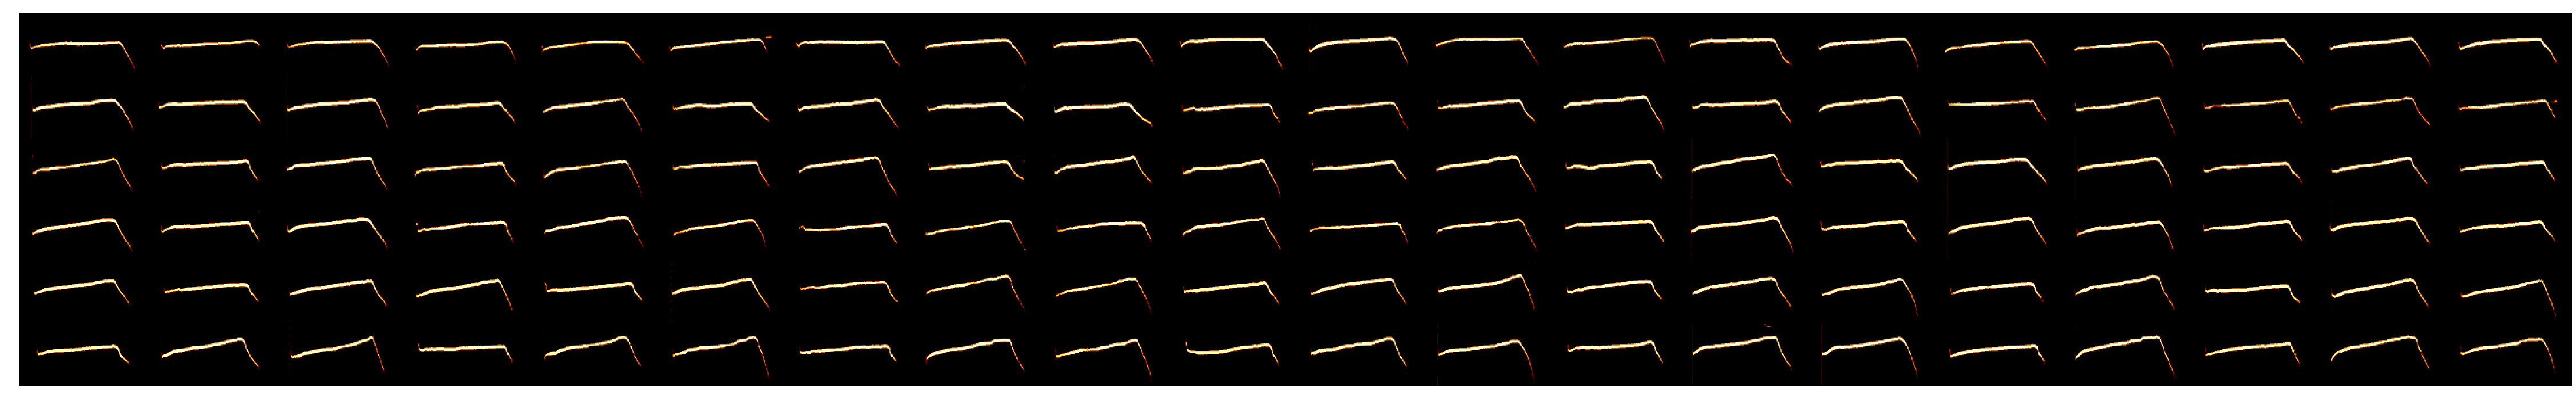

hermes 1660


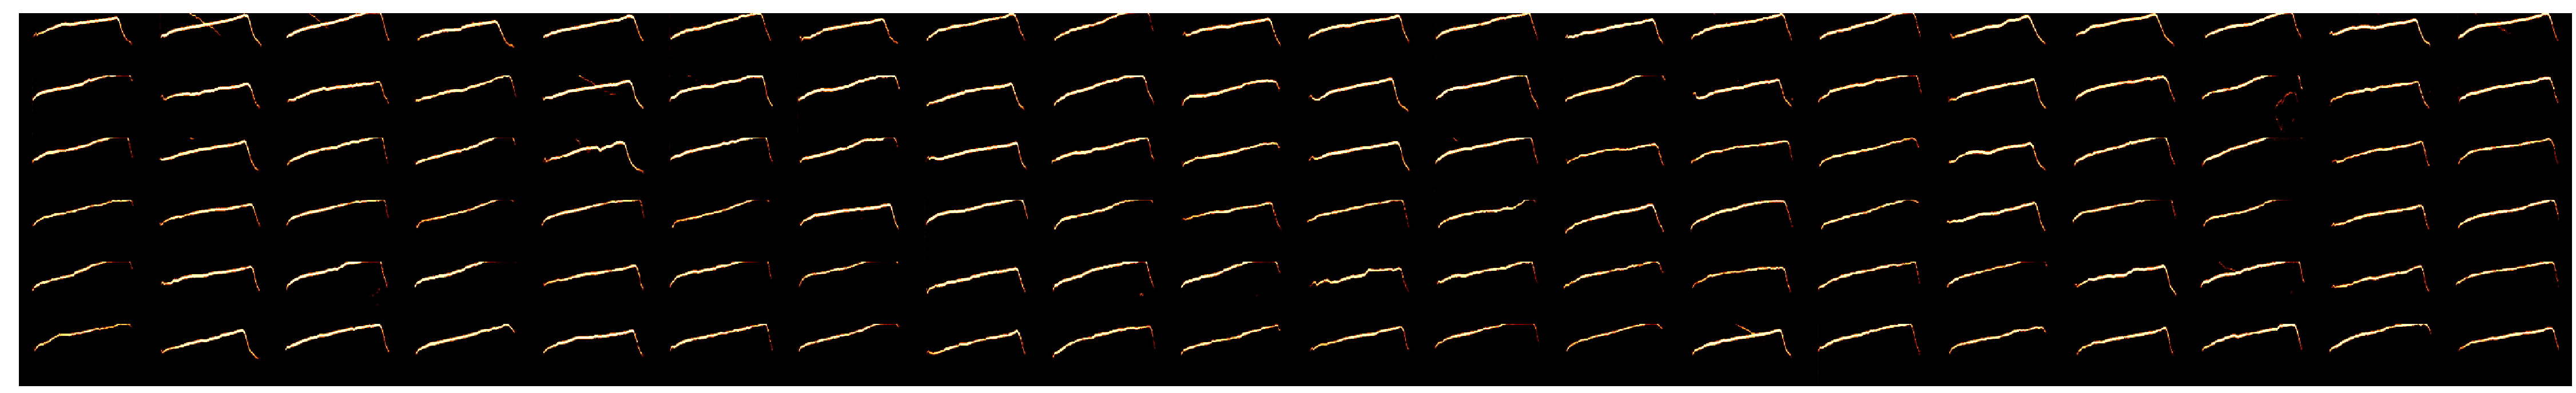

todd 1219


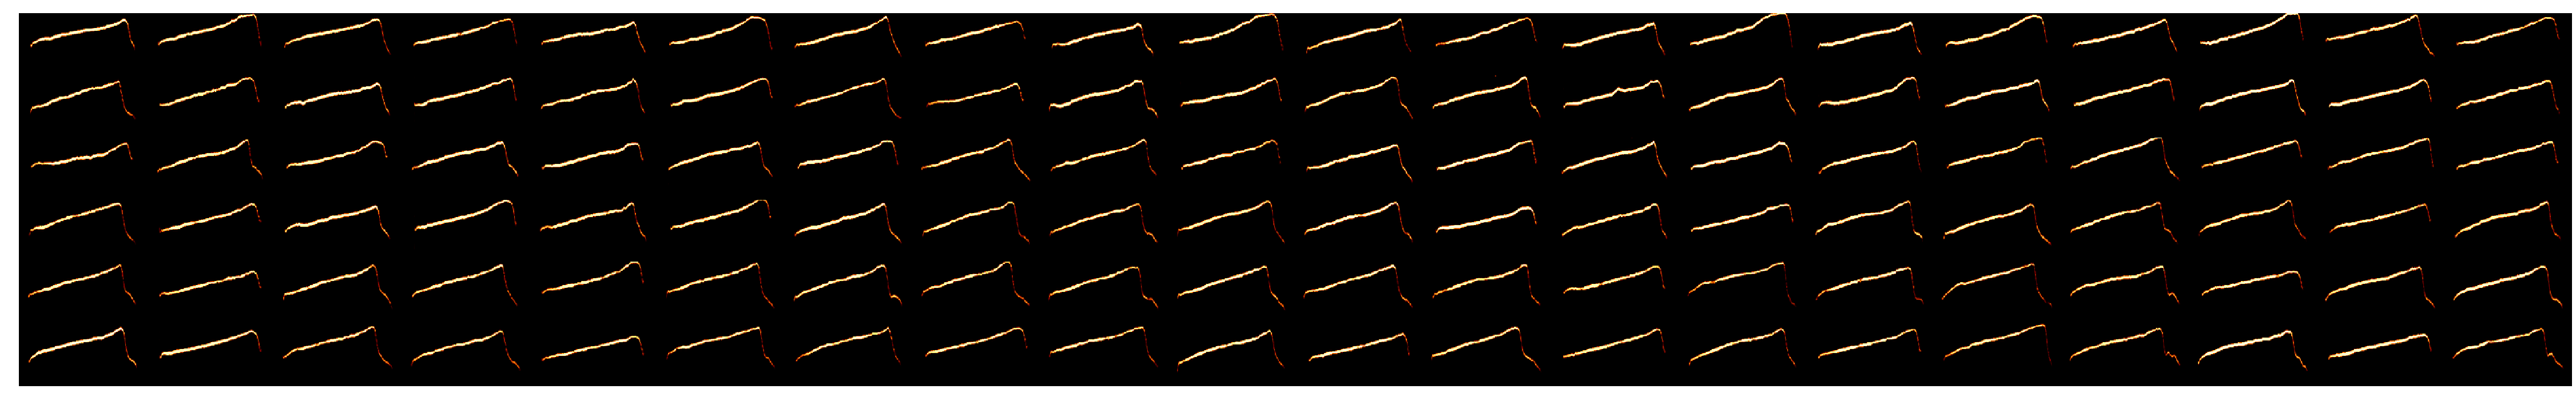

waylon 1207


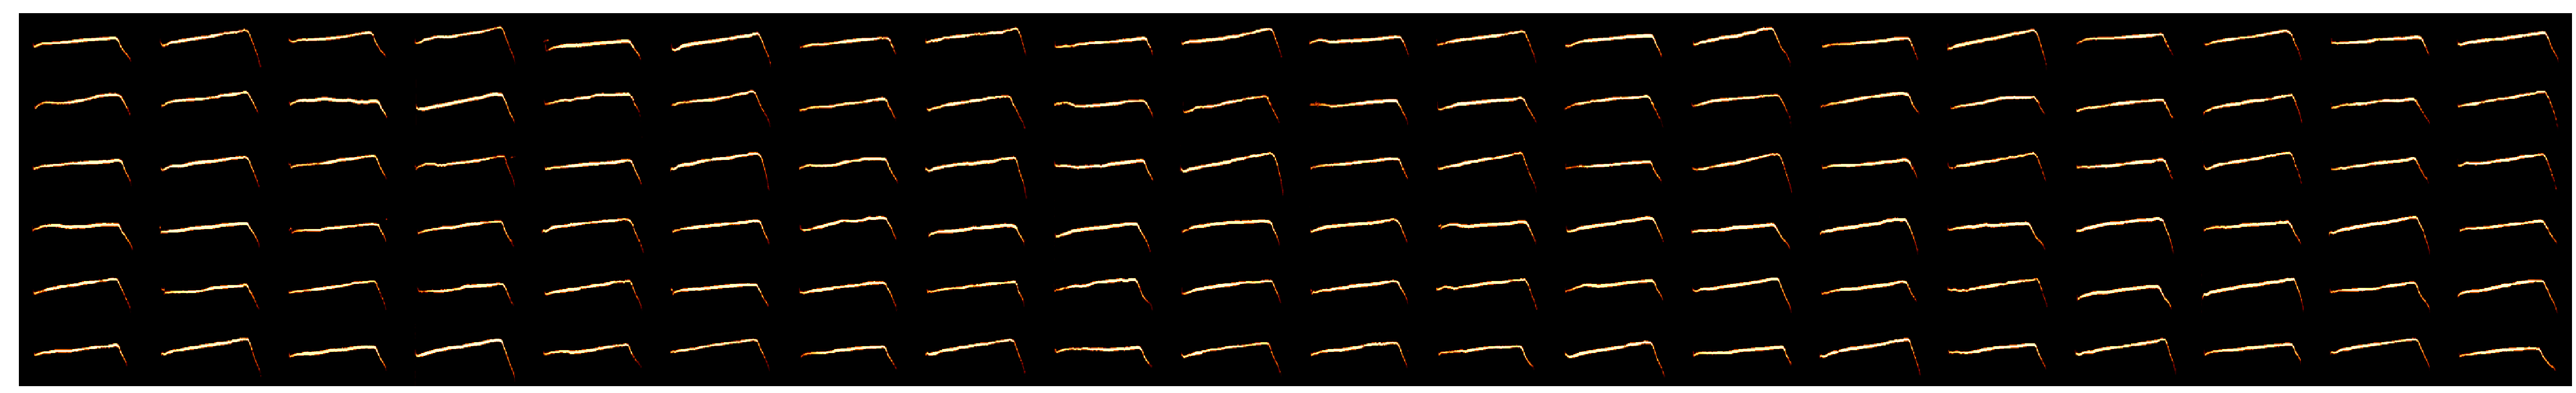

In [52]:
for indv in largest_indvs:
    indv_df = syllable_df[
        (syllable_df.indv == indv)
        & (syllable_df.call_type == "phee")
    ]
    print(indv, len(indv_df))
    plot_voc_canvas(indv_df.specs.values)

### UMAP

In [53]:
import umap
import seaborn as sns


In [54]:
syllable_df[:3]

,index,indv,partner,date,call_type,wav_name,wav,time_in_wav,call_num,call_syll,rate,syll_len,monkey_number,specs
0,0,han,todd,170621,phee,/mnt/cube/Datasets/Marmosets/FromMillerLab/han...,"[5, -2, 0, 3, -3, 1, 3, 3, 0, 1, 3, 3, 1, 0, 1...",[14.792361],0,0,44150,1.259547,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,1,han,todd,170621,phee,/mnt/cube/Datasets/Marmosets/FromMillerLab/han...,"[2, 15, 19, 4, 10, 6, -4, 7, 17, 0, 3, 7, 35, ...",[16.272427],0,1,44150,1.047497,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,2,han,todd,170621,phee,/mnt/cube/Datasets/Marmosets/FromMillerLab/han...,"[-8, -4, 12, 9, 10, -11, -4, 25, 4, 2, 6, -3, ...",[115.95578],1,0,44150,1.255130,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [55]:
syllable_df_li = syllable_df[syllable_df['indv'].isin(largest_indvs)]

In [56]:
specs = np.stack(syllable_df_li.specs.values, axis=2).T
specs_flattened = np.reshape(specs, (np.shape(specs)[0], np.prod(np.shape(specs)[1:])))
len(specs_flattened)

7591

In [57]:
fit = umap.UMAP()
%time u_all = fit.fit_transform(specs_flattened)

CPU times: user 48.6 s, sys: 3.04 s, total: 51.6 s
Wall time: 43.1 s


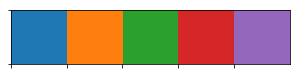

In [58]:
labs = syllable_df_li.indv.values
pal = sns.color_palette(n_colors=len(np.unique(labs)))
sns.palplot(pal)
lab_dict = {lab:pal[i] for i, lab in enumerate(np.unique(labs))}
colors = np.array([lab_dict[i] for i in labs])

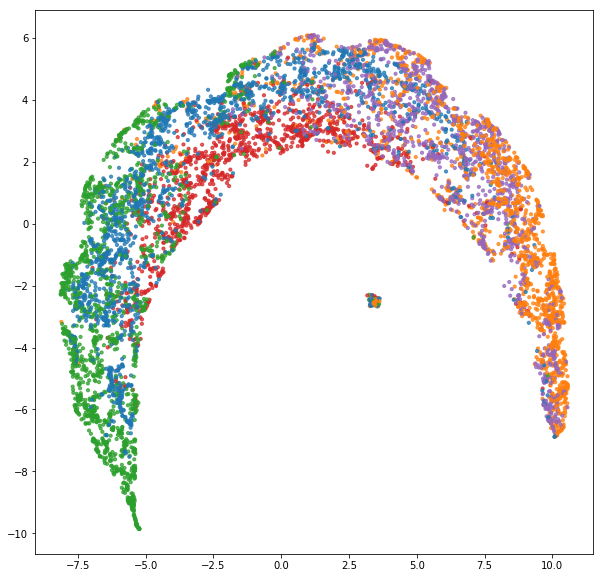

In [59]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(u_all[:,0], u_all[:,1], alpha = 0.75, s=10, color=colors)

In [66]:
name_dict = {name:label for label, name in enumerate(np.unique(syllable_df_li.indv.values))}
name_dict
labs = [name_dict[i] for i in syllable_df_li.indv.values]

In [67]:
fit = umap.UMAP()
%time u_all = fit.fit_transform(specs_flattened, y = labs)

CPU times: user 42.1 s, sys: 2.46 s, total: 44.6 s
Wall time: 34.4 s


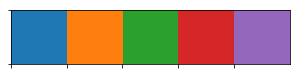

In [68]:
labs = syllable_df_li.indv.values
pal = sns.color_palette(n_colors=len(np.unique(labs)))
sns.palplot(pal)
lab_dict = {lab:pal[i] for i, lab in enumerate(np.unique(labs))}
colors = np.array([lab_dict[i] for i in labs])

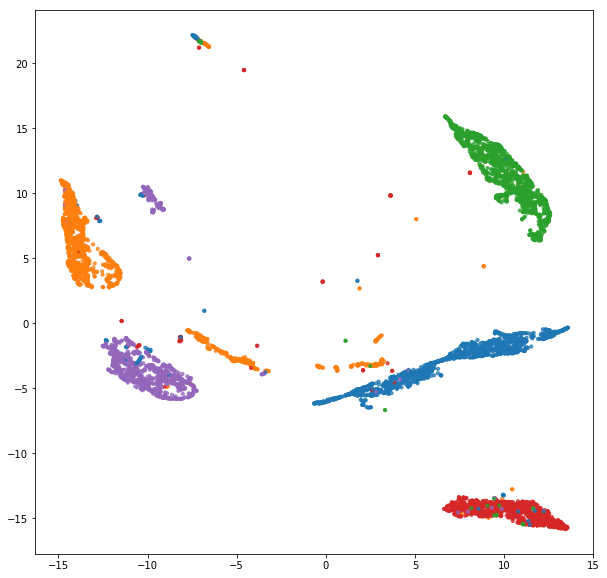

In [69]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(u_all[:,0], u_all[:,1], alpha = 0.75, s=10, color=colors)

### embed a new individual in

In [79]:
smaller_df = syllable_df[syllable_df['indv'].isin(['ares', 'london'])]

In [80]:
smaller_df_specs = np.stack(smaller_df.specs.values, axis=2).T
smaller_df_specs_flattened = np.reshape(smaller_df_specs, (np.shape(smaller_df_specs)[0], np.prod(np.shape(smaller_df_specs)[1:])))
len(specs_flattened)

7591

In [81]:
test_embedding = fit.transform(smaller_df_specs_flattened)

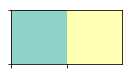

In [82]:
labs = smaller_df.indv.values
pal = sns.color_palette('Set3', n_colors=len(np.unique(labs)))
sns.palplot(pal)
lab_dict = {lab:pal[i] for i, lab in enumerate(np.unique(labs))}
colors_smaller = np.array([lab_dict[i] for i in labs])

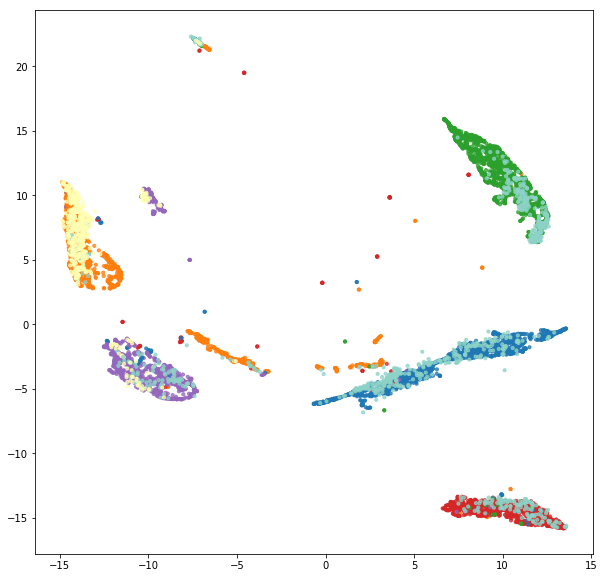

In [83]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(u_all[:,0], u_all[:,1], alpha = 0.75, s=10, color=colors)
ax.scatter(test_embedding[:,0], test_embedding[:,1], alpha = 0.75, s=10, color=colors_smaller)


### plot neural network interpolations back into UMAP space...